In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForMaskedLM
from tqdm.notebook import tqdm
from scipy.stats import spearmanr

from bio_if.data.utils import FastaDataset, CachedEmbedTokenizer
from bio_if.modules.mlp import MLPBlock

In [2]:
tokenizer_fn = CachedEmbedTokenizer('~/.cache/bio_if/facebook/esm2_t33_650M_UR50D/gb1.pt')

In [3]:
train = FastaDataset('../src/bio_if/data/FLIP/gb1/sampled.fasta', split='train', tokenizer_fn=tokenizer_fn)
val = FastaDataset('../src/bio_if/data/FLIP/gb1/sampled.fasta', split='val', tokenizer_fn=tokenizer_fn)
test = FastaDataset('../src/bio_if/data/FLIP/gb1/sampled.fasta', split='test', tokenizer_fn=tokenizer_fn)

In [4]:
# define an MLP
def init_regressor():
    D = 128
    return nn.Sequential(
        MLPBlock(1280, D, use_relu=True),
        MLPBlock(D, D, use_relu=True),
        MLPBlock(D, 1, use_relu=False)
    )

In [5]:
train_dataloader = train.get_dataloader(batch_size=32, shuffle=True, drop_last=True)
val_dataloader = val.get_dataloader(batch_size=32, shuffle=False, drop_last=False)
test_dataloader = test.get_dataloader(batch_size=32, shuffle=False, drop_last=False)
DEVICE = 'cuda:7'

In [6]:
def get_val_loss(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids, labels = batch
            input_ids, labels = input_ids.to(DEVICE), labels.to(DEVICE)
            outputs = model(input_ids).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(dataloader)

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 0 train loss: 1.3963239668887488
Epoch 0 val loss: 1.2564955733039163


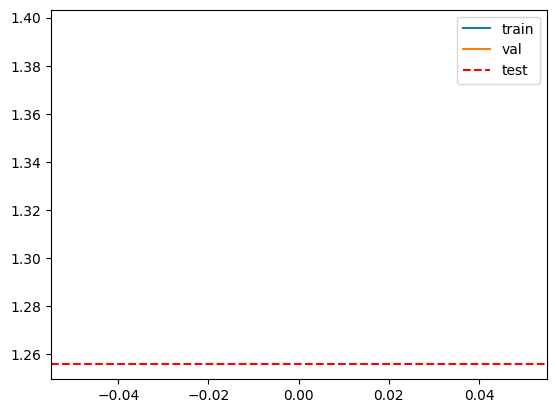

In [7]:
EPOCHS = 1 # 00
N_VAL_ATTEMPTS = 10
LR = 1e-2

loss_fn = nn.MSELoss()
best_val_loss = float('inf')

val_failures = 0
model = init_regressor().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.1, )

losses = []
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for batch in tqdm(train_dataloader):
        input_ids, labels = batch
        input_ids, labels = input_ids.to(DEVICE), labels.to(DEVICE)
        outputs = model(input_ids).squeeze()
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()

    val_loss = get_val_loss(model, val_dataloader, loss_fn)
    print(f'Epoch {epoch} train loss: {train_loss / len(train_dataloader)}')
    print(f'Epoch {epoch} val loss: {val_loss}')
    losses.append((train_loss / len(train_dataloader), val_loss))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        val_failures = 0
    else:
        val_failures += 1
        if val_failures >= N_VAL_ATTEMPTS:
            break

# make a plot of the training and validation losses
train_losses, val_losses = zip(*losses)
test_loss = get_val_loss(model, test_dataloader, loss_fn)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.axhline(test_loss, color='r', linestyle='--', label='test')
plt.legend()

In [8]:
def get_correlation(model, dataloader):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, label = batch
            input_ids, label = input_ids.to(DEVICE), label.to(DEVICE)
            outputs = model(input_ids).squeeze()
            preds.append(outputs)
            labels.append(label)
    preds = torch.cat(preds).numpy(force=True)
    labels = torch.cat(labels).numpy(force=True)
    return spearmanr(preds, labels), preds, labels

Train correlation: SignificanceResult(statistic=0.45463987901901487, pvalue=0.0)
Val correlation: SignificanceResult(statistic=0.4148302963473384, pvalue=1.8947110510183277e-30)
Test correlation: SignificanceResult(statistic=0.4251687247447109, pvalue=1.532717021480404e-77)


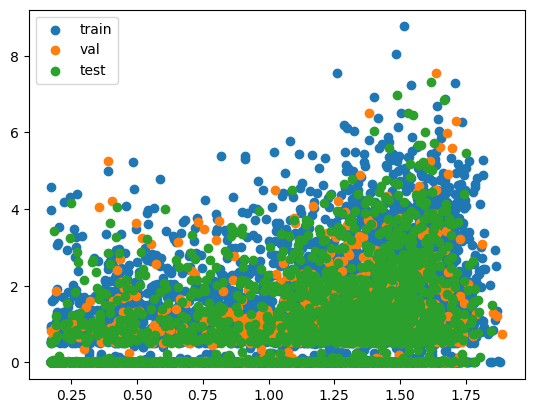

In [9]:
print(f"Train correlation: {get_correlation(model, train_dataloader)[0]}")
print(f"Val correlation: {get_correlation(model, val_dataloader)[0]}")
print(f"Test correlation: {get_correlation(model, test_dataloader)[0]}")
# make plot of 3 different correlations
_, train_preds, train_labels = get_correlation(model, train_dataloader)
_, val_preds, val_labels = get_correlation(model, val_dataloader)
_, test_preds, test_labels = get_correlation(model, test_dataloader)

plt.scatter(train_preds, train_labels, label='train')
plt.scatter(val_preds, val_labels, label='val')
plt.scatter(test_preds, test_labels, label='test')
plt.legend()

In [13]:
# compute influence function of the model
from bio_if.modules.influence import influence, get_ekfac_factors_and_pseudo_grads

In [11]:
# turn train dataset into a list
train_list = list(train)
test_list = list(test)

# "tokenize" the first value of each tuple
train_list = [(tokenizer_fn(x).reshape(1, -1), y) for x, y in train_list]
test_list = [(tokenizer_fn(x).reshape(1, -1), y) for x, y in test_list]

In [12]:
if_vals = influence(model, list(model), test_list, train_list, train_list, 5, DEVICE, torch.nn.functional.mse_loss)

Computing EKFAC factors and pseudo gradients


  0%|          | 0/6289 [00:00<?, ?it/s]

/home/cadegord/projects/bio-if/src/bio_if/modules/influence.py:61: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(output, target)
100%|██████████| 6289/6289 [00:21<00:00, 293.85it/s]


Computing search gradients


  0%|          | 0/6289 [00:00<?, ?it/s]/home/cadegord/projects/bio-if/src/bio_if/modules/influence.py:96: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(output, target)
100%|██████████| 6289/6289 [00:12<00:00, 516.18it/s]


Computing iHVP
dtheta
<class 'torch.Tensor'>
torch.Size([128, 1281])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:7 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [ ]:
_, _, p = get_ekfac_factors_and_pseudo_grads(model, train_dataloader, list(model), DEVICE, torch.nn.functional.mse_loss)